#**Aim**
The aim of the following program is to develop a scoring model for used oil suppliers across the nation. Scores are provided to suppliers based on different parameters (distance, quantity of used oil transported etc) serves two purposes:
1. To judge the feasibility of bringing used oil to the recyclers (in this case IFP Petro)
2. To prioritize different suppliers based on the parameters of the supplied oil - to be used in the web application developed to digitalize used oil supply to the recyclers
3. To get a sense of whether the price offered by the recyclers to the suppliers is in the correct range - according to the quantity, transportation charges to bring the oil to the recycler etc.
---

#**Dataset**
The dataset is a .csv file with the parameters - 'True Quantity' and 'Rate per litre' provided for each address of the supplier.

- First, using Google Maps API (through functions written in Google App Script) the distances for all the locations of suppliers and the central location of the recycler (here, IFp Petro)
- Second, upload the .csv file in the Google Colab File Section
---
#**Approach**


##**Importing necassary libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import MiniBatchKMeans
from scipy import optimize

##**Functions to clean up the dataset**
The following are some function to 'clean up' the datasets.
1. `remove_outliers(df,columns,n_std)` : It removes the 'outliers' in the data (which are very very few) i.e. data-points which are n_std (n standard deviations) away from the mean, are removed - to get better clustering of data. In this case, the value of n_std is chosen to be 3

2. `plot_dataframe(df, color_map, numclusters)` : It plots (scatter plot) the entire dataframe
  - Distance along x axis
  - Quantity of used oil along y axis 
  - Rate of oil along z axis
---

In [ ]:
def remove_outliers(df,columns,n_std):
    for col in columns:
      if col == "Item":
        continue
      else:
        print('Removing outliers in column: {}'.format(col))
        
        mean = df[col].mean()
        sd = df[col].std()
        
        df = df[(df[col] <= mean+(n_std*sd))]
        
    return df
def plot_dataframe(df, color_map, numclusters):
    '''Plotting the Clusters'''
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')
    ax.scatter3D(df['Distance'],df['True Quantity'], df['Rate per litre'], c= color_map)
    plt.xlabel('Distance (Normalized)')
    plt.ylabel('True Quantity (Normalized)')
    ax.set_zlabel(r'Rate per Litre (Normalized)', labelpad=30)
    plt.savefig("usedOilDataset_clusters"+str(numclusters)+".png")

##**Reading the file and cleaning up the dataset**
1. The data is read from the .csv file into the Pandas dataframe
  - Rows in which some value is NaN are removed
  - Rows in which there are no results for the given supplier address (which shows 'ZERO_RESULTS' or 'Error: NOT_FOUND' in the Distance column)
2. Outliers are removed
3. Since the values of distances are generally a magnitude larger than the values of used oil quantity, all the values are normalized 

$$
x_{norm} = \frac{x - \bar{x}}{\sigma_x}
$$

$\bar{x}$ - mean of x and $\sigma_x$ - standard deviation of x
4. Prints the dataframe
---

In [ ]:
df = pd.read_csv('usedOilDataset.csv')
cols = ['True Quantity','Distance', 'Rate per litre']
df = df[cols]


'''Formatting the csv data to extract relevant information into the dataframe'''
# get names of indexes for which address cannot be found by google maps API or gave multiple results on Google Maps
index_names = df[ (df['Distance'] == 'Error: ZERO_RESULTS') | (df['Distance'] == 'Error: NOT_FOUND') ].index
# drop these row indexes from dataFrame
df.drop(index_names, inplace = True)
# drop rows in dataframe which have value as NaN
df.dropna(subset=['Distance'], inplace=True) 
# To reset the indices
df = df.reset_index(drop = True)
# converting each value of column to a string
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

'''Remove the outliers'''
df = remove_outliers(df,cols,3)

df_true = df[cols]

'''Normalizing the dataset'''
for col in df.columns:
  if col == "Item":
    continue
  else:
    df[col] = (df[col] - df[col].mean())/df[col].std()
df

Removing outliers in column: True Quantity
Removing outliers in column: Distance
Removing outliers in column: Rate per litre


,True Quantity,Distance,Rate per litre
1,2.158066,3.203840,1.463293
2,-0.539734,-0.402653,0.197182
4,-0.539734,-0.389911,0.093381
5,-0.539734,-0.431181,0.085693
6,-0.539734,-0.446448,0.074159
...,...,...,...
958,-0.205829,-0.275692,-2.185107
959,-0.205829,-0.368315,-2.185107
960,-0.497996,-0.402653,-0.567867
961,-0.497996,-0.395404,-0.605030


##**Discretized grading of used oil**
Since the rates given in the dataset are ad-hoc, and therefore can not be depended on for analysis. Neither can one just apply some random formula for assigning scores - as, again, there is no way to validate the data. Therefore, the entire process cannot be automated, manual input is required (as described further)

---

###**Approach followed**
1. Divide the datapoints into $n$ groups (here n is chosen to be 5), using mini-batch k-means algorithm. Each group defines a class of suppliers.
2. Each class of suppliers has a mean distance value and quantity of used oil supplied which characterizes that class.
3. This step is where manual intervention is required. One can observe the graph of the mean distance and quantity value on the graph plotted, and using the data of transportation costs (plus other overheads) and say, the amount of revenue that can be generated by that quantity of oil, one has to set the score for the mean datapoints (say, on a scale from $[0,100]$) 
4. We use the following score for each location:

$$
score_i = |\alpha|.quantity_i + |\beta|.\frac{1}{distance_i}
$$
under the constraint $\alpha^2 + \beta^2 = max(category\_score)$, category_score is the array of scores manually entered
- The remaining task is to determine the values of $\alpha$ and $\beta$ 
- Rather than choosing the values randomly, we define the follwoing loss function:
$$
L = \frac{1}{N}\sum_i(score_i - category\_score_i)^2
$$
where $category\_score_i$ is the score set manually for the group (category) to which datapoint $i$ belongs
---

## **Intuition behind the approach:**
  - The user does not have to calculate the score for all the 1000 or so datapoints, so this automates a huge part of the manual work.
  - The loss function to be minimized is kind of the mean of squared error from the score given to a particular category.
  - Minimizing the function, we choose those values of $\alpha$ and $\beta$ so that our score for the datapoint gets as close to the score assigned to that category - simultaneously, partially validating our score value.
  ---

### **Visualizing the dataset**

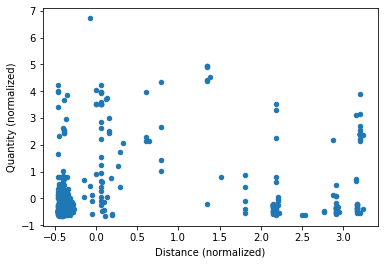

In [ ]:
df.plot.scatter(x = "Distance", y = "True Quantity")
plt.ylabel("Quantity (normalized)")
plt.xlabel("Distance (normalized)")
plt.show()

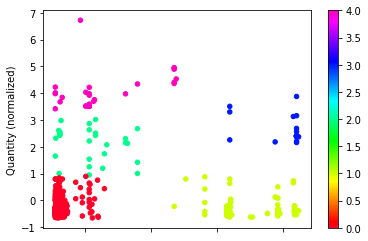

In [ ]:
'''Performing Clustering on the Dataset'''
X = df[['True Quantity','Distance']].copy()
kmeans = MiniBatchKMeans(n_clusters=5,random_state=0,batch_size=int(len(df.index)/2),max_iter=1000).fit_predict(X)

'''Plotting the Clusters'''
df.plot.scatter(x = "Distance", y = "True Quantity", c=kmeans, colormap = "gist_rainbow")
plt.ylabel("Quantity (normalized)")
plt.xlabel("Distance (normalized)")
plt.show()

The locations have been divided into 5 categories. The categories have been ranked according to the average rate of the group.

In [ ]:
df.insert(3, "Category", kmeans, True)
df_true.insert(3, "Category", kmeans, True)

In [ ]:
avg_df = df_true.groupby('Category').mean()
avg_df.insert(3, "Max Rate", df_true.groupby('Category').max()['Rate per litre'].to_numpy(), True)
avg_df.insert(3, "Min Rate", df_true.groupby('Category').min()['Rate per litre'].to_numpy(), True)
avg_df

,True Quantity,Distance,Rate per litre,Min Rate,Max Rate
Category,,,,,
0,2038.219321,29.040018,24.019396,1.00,47.00
1,2106.308275,1276.549977,23.639186,1.72,43.95
2,14548.361757,233.142333,30.255556,1.59,41.10
3,17203.913043,1504.569348,26.620870,19.43,55.90
4,25044.706496,310.174862,25.330000,1.59,43.95


### **Plotting the mean points for each category**

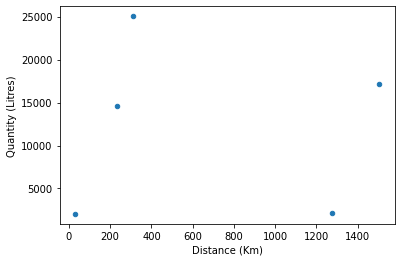

In [ ]:
avg_df.plot.scatter(y = "True Quantity", x="Distance")
plt.ylabel("Quantity (Litres)")
plt.xlabel("Distance (Km)")
plt.show()

##**Continuous grading of used oil**

In [ ]:
'''ENTER THE SCORES CORRESPONDING TO EACH CATEGORY BELOW'''
'''THE INDICES OF THE ARRAYS ARE THE CATEGORIES - MATCH THOSE WITH THE VALUES IN THE TABLE GIVEN ABOVE'''
score_manual = [0]*5;
score_manual[4] = 100
score_manual[2] = 90
score_manual[0] = 50
score_manual[3] = 10
score_manual[1] = 1

mean_distance = (1/df_true['Distance']).mean()
mean_quantity = df_true['True Quantity'].mean()
def score(alpha,beta, distance, quantity, category):
  return (abs(alpha)*quantity/mean_quantity + abs(beta)*(1/(distance*mean_distance)) - score_manual[category])**2

def const(s):
  return s[0]*s[0] + s[1]*s[1] - max(score_manual)

'''TRUE (NOT NORMALIZED) VALUES ARE USED IN CALCULATIONS'''
def lossfunction(parameters):
  alpha,beta = parameters
  sum = 0
  for i in range(5):
    temp = df_true[df_true['Category'] == i] 
    for j in range(len(temp.index)):
      sum+=score(alpha,beta, temp['Distance'].iloc[j], temp['True Quantity'].iloc[j],i)
  return sum/len(df.index)

print(10/1276/mean_distance) # To see the magnitude of values of first two terms in loss function 
print(1000/mean_quantity) # Magnitudes shouldn't be too far apart

0.07397718729438393
0.28531347588108913


###**Values of parameters**

In [ ]:
first_guess = [0.5, 0.5]
constarnt = {'type':'eq', 'fun': const}
result = optimize.minimize(lossfunction, first_guess, constraints=constarnt) # Minimizing the Loss function
print("alpha is", abs(result.x[0]))
print("beta is", abs(result.x[1]))

alpha is 7.931508697015463
beta is 6.090252030023195
